# Predicting Sepsis Survival Based on Clinical Records

## Summary

This project aims to explore whether basic clinical and demographic factors could be used to predict sepsis survival outcomes. Specifically, the variables Age, Sex, and Sepsis Episode Number were examined to determine their influence on a patient’s probability of survival after hospitalization.

A dataset of over 110,000 hospital admissions from Norway (2011–2012) was obtained from the UCI Sepsis Survival Minimal Clinical Records repository. After the Exploratory Data Analysis, a Logistic Regression model was trained and tuned via randomized search with cross-validation. Model performance was evaluated using standard metrics, including ROC-AUC, Precision, Recall, and F1-score, and further interpreted using SHAP (SHapley Additive exPlanations) values to assess feature importance and contribution.

The results showed that the model achieved a ROC-AUC of 0.59, with high recall but limited discriminative power. Age emerged as the strongest predictor of survival: as you get older your probability of survival decreases, with SHAP values confirming its dominant influence on the model’s output. In contrast, Sex and Episode Number had minimal impact on predictions. These findings suggest that while demographic factors provide limited predictive ability on their own, Age remains a crucial indicator of mortality risk in sepsis patients.

The analysis highlights the need for more clinical features to improve model accuracy, showing that Age and Gender are not good predictors for survival probabilities.

## Introduction

Sepsis is a life-threatening condition that occurs when the immune system overreacts to an infection causing organ dysfunction (Cleveland Clinic, 2022). The reaction can cause damage to tissues and organs and it can lead to severe sepsis from low blood pressure as a result of inflammation throughout the body. The last stage is septic shock which is when blood pressure is so low that it cannot supply enough blood to vital organs such as the brain, kidneys, and liver, causing them to fail and possibly leading to death. Generally, sepsis is usually caused by bacterial infections but it could be from parasites, viruses, and fungi infections in the bloodstream, lungs. and urinary tract (World Health Organization, 2024).  Common symptoms for sepsis include fever, fast heart rate, rapid breathing, low blood pressure, confusion, skin rash, chills and shivering, etc (Canadian Cancer Society, 2024).

Since sepsis requires urgent medical care, a machine learning algorithm that can be used to predict if a patient is likely to survive or pass away after being hospitalized for a specific time interval from septic shock is crucial. Sepsis is often associated with immediate death risk and it can kill patients as fast as within an hour if not treated promptly. An accurate and fast machine learning model will help medical staff prioritize patients who need more urgent care and possibly save more patients from this life-threatening condition. Also, this study aims to identify which factor contributes to whether a patient is more likely to be dead from sepsis. Therefore, if a machine learning algorithm can promptly and accurately classify patients, this could lead to a better sepsis patient prioritization and save more lives.

To answer this question and produce a machine learning model, the datasets of 110,204 admissions of 84,811 hospitalized subjects between 2011 and 2012 in Norway who were diagnosed with infections, systemic inflammatory response syndrome, sepsis by causative microbes, or septic shock will be utilized to analyze and build a machine learning algorithm. It was sourced from the UCI Machine Learning Repository (Chicco & Jurman, 2020). Each row in the data set represents each patient information including their age, sex, and number of prior sepsis episodes. There is an outcome of each patient whether they survive at a time of about 9 days after being hospitalized in each row. All the patients' admissions are only defined by the novel Sepsis-3 definition.

## Exploratory Data Analysis (EDA)

EDA is conducted first to see if any data wrangling is needed before proceeding to building a machine learning model.

In [1]:
from utils import *

RANDOM_STATE = 15
sns.set(style="whitegrid")

/Users/eligoze/miniforge3/envs/sepsis_survival_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = load_ucisepsis('s41598-020-73558-3_sepsis_survival_primary_cohort.csv')
test_df = load_ucisepsis('s41598-020-73558-3_sepsis_survival_study_cohort.csv')

train_df.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


In [ ]:
# Rename column names
train_df = train_df.rename(
    columns={
        "age_years": "age",
        "sex_0male_1female": "sex",
        "hospital_outcome_1alive_0dead": "hospital_outcome",
    }
)

test_df = test_df.rename(
    columns={
        "age_years": "age",
        "sex_0male_1female": "sex",
        "hospital_outcome_1alive_0dead": "hospital_outcome",
    }
)

# Convert sex to categorical
train_df["sex"] = train_df["sex"].map({0: "male", 1: "female"})
test_df["sex"] = test_df["sex"].map({0: "male", 1: "female"})

# Convert target to categorical
train_df["hospital_outcome_cat"] = train_df["hospital_outcome"].map(
    {0: "Died", 1: "Survived"}
)
test_df["hospital_outcome_cat"] = test_df["hospital_outcome"].map(
    {0: "Died", 1: "Survived"}
)

In [4]:
# Show the stats of each column
train_df.describe()

,age,episode_number,hospital_outcome
count,110204.000000,110204.000000,110204.000000
mean,62.735255,1.349379,0.926455
std,24.126806,0.751799,0.261031
min,0.000000,1.000000,0.000000
25%,51.000000,1.000000,1.000000
50%,68.000000,1.000000,1.000000
75%,81.000000,1.000000,1.000000
max,100.000000,5.000000,1.000000


In [5]:
train_df["sex"].value_counts(True, dropna=False)

sex
male      0.526052
female    0.473948
Name: proportion, dtype: float64

In [6]:
train_df["hospital_outcome_cat"].value_counts(True, dropna=False)

hospital_outcome_cat
Survived    0.926455
Died        0.073545
Name: proportion, dtype: float64

In [7]:
# Check if there are any NAs in the train df
train_df.isna().mean()

age                     0.0
sex                     0.0
episode_number          0.0
hospital_outcome        0.0
hospital_outcome_cat    0.0
dtype: float64

From the current train and test datasets, all the data are already clean. Age is an integer from 0 to 100. Sex is either 0 (Male) or 1 (Female). Number of prior Sepsis episodes is an integer ranging from 1 to 5. There are no NA values in any columns, so no data imputation is needed.

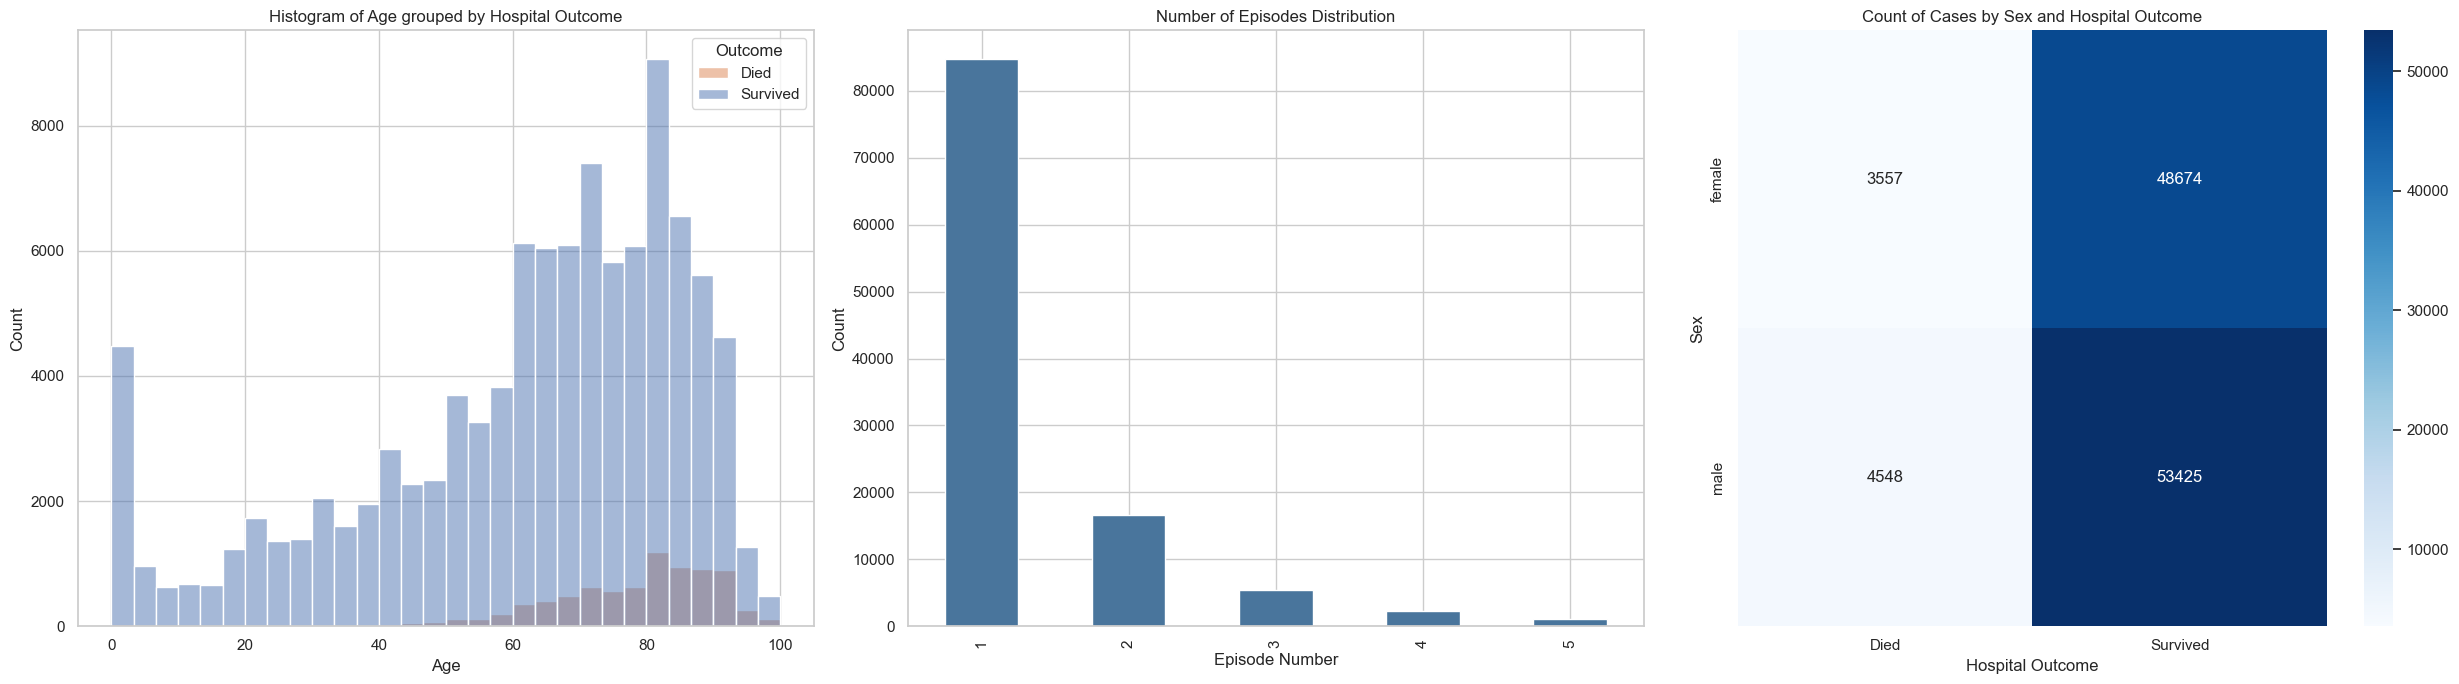

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Histogram of Age grouped by target
sns.histplot(data=train_df, x="age", hue="hospital_outcome_cat", bins=30, ax=axes[0])
axes[0].set_title("Histogram of Age grouped by Hospital Outcome")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
axes[0].legend(title="Outcome", labels=["Died", "Survived"])

# Barplot of Number of Episodes
train_df["episode_number"].value_counts().sort_index().plot(
    kind="bar", color="#49759c", ax=axes[1]
)
axes[1].set_title("Number of Episodes Distribution")
axes[1].set_xlabel("Episode Number")
axes[1].set_ylabel("Count")

# Heatmap: Hospital Outcome vs Sex
pivot_sex_target = train_df.pivot_table(
    index="sex", columns="hospital_outcome_cat", aggfunc="size", fill_value=0
)
sns.heatmap(pivot_sex_target, annot=True, fmt=".0f", cmap="Blues", ax=axes[2])
axes[2].set_title("Count of Cases by Sex and Hospital Outcome")
axes[2].set_xlabel("Hospital Outcome")
axes[2].set_ylabel("Sex")

plt.tight_layout()
plt.show()

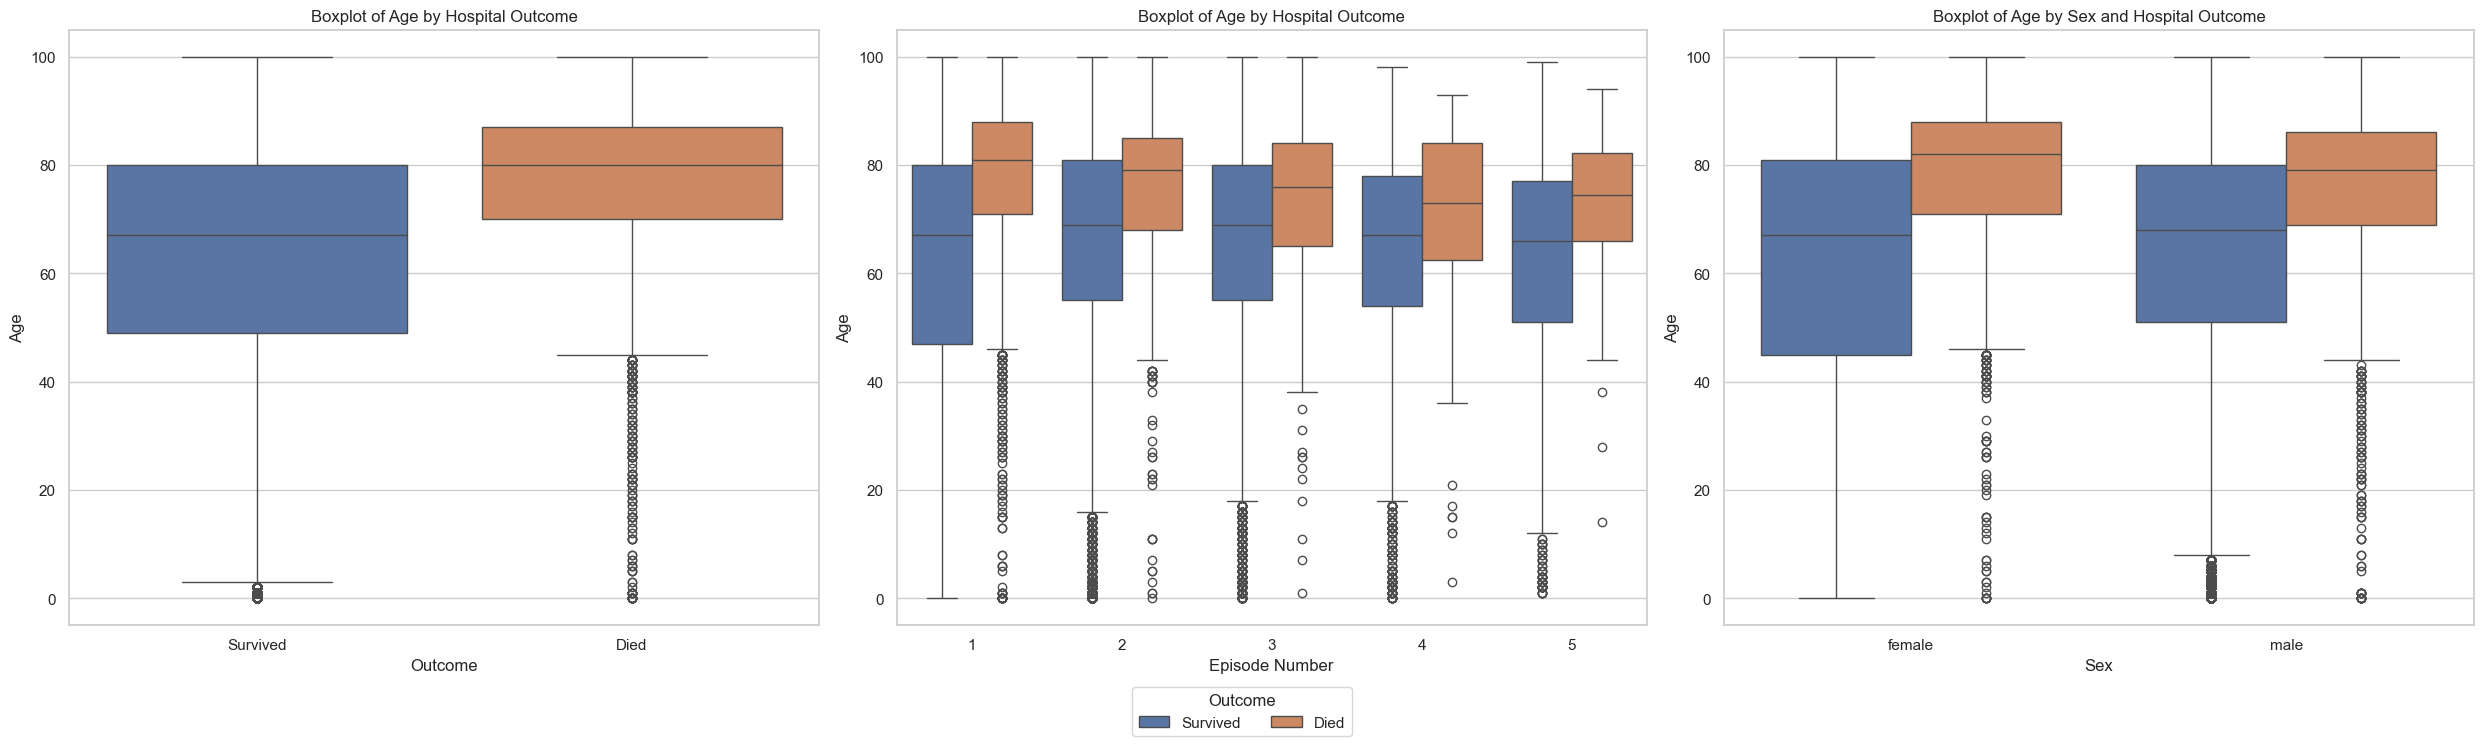

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Boxplot of Age by Hospital Outcome
sns.boxplot(
    data=train_df,
    x="hospital_outcome_cat",
    y="age",
    hue="hospital_outcome_cat",
    ax=axes[0],
)
axes[0].set_title("Boxplot of Age by Hospital Outcome")
axes[0].set_xlabel("Outcome")
axes[0].set_ylabel("Age")

# Boxplot of Age by Hospital Outcome and Episode Number
sns.boxplot(
    data=train_df, x="episode_number", y="age", hue="hospital_outcome_cat", ax=axes[1]
)
axes[1].set_xlabel("Episode Number")
axes[1].set_ylabel("Age")
axes[1].set_title("Boxplot of Age by Hospital Outcome")
axes[1].legend_.remove()
# Boxplot of Age by Sex and Hospital Outcome
sns.boxplot(data=train_df, x="sex", y="age", hue="hospital_outcome_cat")
axes[2].set_xlabel("Sex")
axes[2].set_ylabel("Age")
axes[2].set_title("Boxplot of Age by Sex and Hospital Outcome")
axes[2].legend_.remove()

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Outcome",
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.075),
)

plt.tight_layout()
plt.show()

We can see from the histogram and bar plots above that there is an imbalance of datasets between alive patients and dead patients. This needs to be taken into account when building a machine learning model.

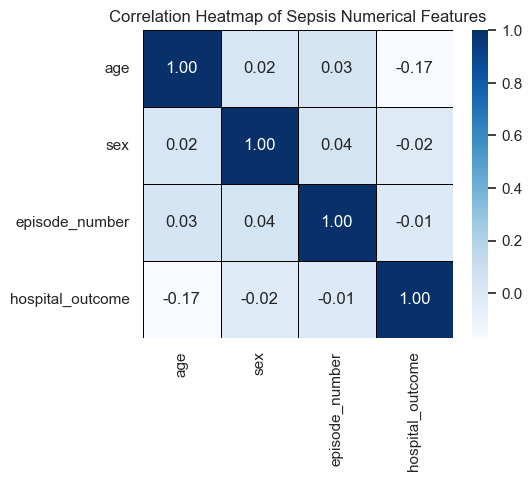

In [ ]:
df_encoded = train_df[["age", "sex", "episode_number", "hospital_outcome"]].copy()

# Convert categories to 0/1
df_encoded["sex"] = df_encoded["sex"].astype("category").cat.codes

correlation_matrix = df_encoded.corr()


plt.figure(figsize=(5, 4))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    linewidths=0.5,
    linecolor="black",
)
plt.title("Correlation Heatmap of Sepsis Numerical Features")
plt.show()

From the correlation heatmap above, it seems like age is the factor that contributes to the hospital outcome the most due to its highest magnitude in correlation. Sex and episode number seem to have lower correlation values compared to age.

### EDA key findings

- **Highly imbalanced target**: The dataset contains a mayority of Sepsis survivors (93%). This suggests the use of specific metrics (e.g., recall, precision, aucpr) and resampling techniques to address class imbalance.
- **Weak predictors**: Correlation analysis and visualizations showed that there are no strong associations between any of the features and the target. This indicates that by themselves, these features may have very poor predictive power. We expect the model to perform poorly.
- **No Multicolinearity**: No high correlation between features, so no risk of multicolinearity.
- **What preprocessing needs to be applied**:
    - *Age* is a numeric variable and should be standardized, no missing values.
    - *Sex* is a binary categorical variable with no order of magnitude and should be one-hot encoded, no missing values.
    - *Episode number* is a numeric variable and should be standardized, no missing values.

## Modeling 

In [ ]:
X_train, y_train = (
    train_df.drop(columns=["hospital_outcome", "hospital_outcome_cat"]),
    train_df["hospital_outcome"],
)

X_test, y_test = (
    test_df.drop(columns=["hospital_outcome", "hospital_outcome_cat"]),
    test_df["hospital_outcome"],
)

In [ ]:
numeric_features = ["age", "episode_number"]
categorical_features = ["sex"]
features = numeric_features + categorical_features

# As suggested by EDA, we standardize numeric features and one-hot encode categorical features
lr_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), categorical_features),
)

In [ ]:
# Create pipeline
logistic_pipe = make_pipeline(
    lr_preprocessor,
    LogisticRegression(random_state=RANDOM_STATE),
)
# Tune model
param_grid = {
    "logisticregression__C": loguniform(1e-4, 1e2),
    "logisticregression__class_weight": [None, "balanced"],
    "logisticregression__max_iter": [500, 1000, 2000, 3000, 4000, 5000],
}
lr_random_search = RandomizedSearchCV(
    logistic_pipe,
    param_grid,
    n_iter=150,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True,
    cv=5,
)
lr_random_search.fit(X_train, y_train)
# Get best model
lr_best_model = lr_random_search.best_estimator_

# saving model
joblib.dump(lr_best_model, "../models/logistic_reg.pkl")

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [ ]:
# adapted from DSCI 573 lecture 1
# Classification Metrics
y_pred_train = lr_best_model.predict(X_train)
y_pred_test = lr_best_model.predict(X_test)
roc_auc_train = roc_auc_score(y_train, lr_best_model.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, lr_best_model.predict_proba(X_test)[:, 1])
precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

pd.DataFrame(
    {
        "dataset": ["train", "test"],
        "roc auc": [roc_auc_train, roc_auc_test],
        "precision": [precision_train, precision_test],
        "recall": [recall_train, recall_test],
        "F1 score": [f1_train, f1_test],
    }
)

,dataset,roc auc,precision,recall,F1 score
0,train,0.70589,0.926455,1.0,0.961823
1,test,0.58812,0.810719,1.0,0.895466


By looking at the classification metrics above we can directly see that the model has overfit: train ROC-AUC is 0.70 while test ROC-AUC is 0.59. This is likely due to the very limited number of features available to train the model, which limits its ability to generalize well to unseen data.

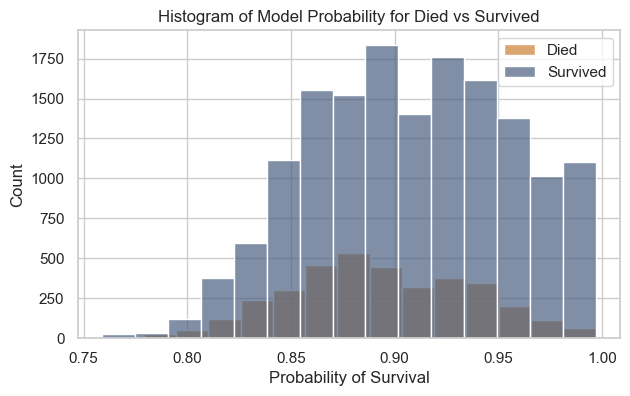

In [25]:
died = test_df.loc[test_df["hospital_outcome_cat"] == "Died"]
y_hat_died = lr_best_model.predict_proba(died[features])[:, 1]
survived = test_df.loc[test_df["hospital_outcome_cat"] == "Survived"]
y_hat_survived = lr_best_model.predict_proba(survived[features])[:, 1]

plt.figure(figsize=(7, 4))
sns.histplot(
    data=y_hat_died, color="#CD7F32", kde=False, label="Died", alpha=0.7, bins=15
)
sns.histplot(
    data=y_hat_survived,
    color="#4A5F80",
    kde=False,
    label="Survived",
    alpha=0.7,
    bins=15,
)
plt.xlabel("Probability of Survival")
plt.legend()
plt.title("Histogram of Model Probability for Died vs Survived")
plt.show()

The histogram above allows us to visualize the distribution of predicted probabilities for both classes (Survived vs Died) in the test set. We can understand why is AUC-ROC so low: The model is not bein able to separate between clases, both distributions are completely overlapped. Although there is a slight shift to the right for the Survived class, it is not enough to make accurate predictions.

## Model Explanainability

In [35]:
intercept = lr_best_model.named_steps["logisticregression"].intercept_
coeffs = lr_best_model.named_steps["logisticregression"].coef_

print(f"Model intercept: {intercept}")
print(f"Model coefficents:")
dict(zip(features, coeffs[0]))

Model intercept: [2.99292559]
Model coefficents:


{'age': np.float64(-1.068984650217961),
 'episode_number': np.float64(-0.018064044747291726),
 'sex': np.float64(-0.17849932623069037)}

$$
logit(p) = 2.993 - 1.069(Age) - 0.018(Episode\ Number) - 0.178(Is\ Male)
$$

Even though the model has poor performance, we can still interpret the coefficients from the logistic regression and understand the associations that the mdoel found. Given the intercept and coefficients above, we can see that:
- The intercept is 2.993, which is the log odds of survival when all features are zero. It's remarkably high and this is due to the class imbalance (93% survival rate).
- Age has a coefficient of -1.069, indicating that an increase of one year of age is associated with an expected decrease of the log odds of survival of 1.069. This feature has the largest impact on the model's predictions.
- Episode number has a coefficient of -0.018, indicating that an increase of one Episode Number is associated with an expected decrease of the log odds of survival of 0.018. This feature is the least important of the three.
- Is Male has a coefficient of -0.178, indicating that being male is associated with an expected decrease of the log odds of survival of 0.178.

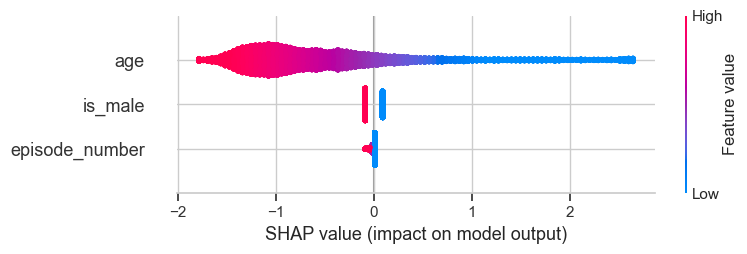

Mean absolute SHAP values are shown below & higher values indicate higher feature importance.

age: 0.86477
is_male: 0.08907
episode_number: 0.01442


In [40]:
feature_names = lr_best_model.named_steps["columntransformer"].get_feature_names_out()
clean_feature_names = []
for f in feature_names:
    clean = f.replace("onehotencoder__", "").replace("standardscaler__", "")
    # renaming sex_1
    if clean == "sex_male":
        clean_feature_names.append("is_male")
    elif clean == "sex_female":
        clean_feature_names.append("is_female")
    else:
        clean_feature_names.append(clean)


# Transform test set through the preprocessor
X_train_s = lr_best_model.named_steps["columntransformer"].transform(X_train)
X_test_s = lr_best_model.named_steps["columntransformer"].transform(X_test)

# Extract the trained LogisticRegression model
logreg = lr_best_model.named_steps["logisticregression"]

# SHAP explainer
explainer = shap.LinearExplainer(logreg, X_train_s)
shap_values = explainer.shap_values(X_test_s)
shap.summary_plot(shap_values, X_test_s, feature_names=clean_feature_names)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = list(zip(clean_feature_names, mean_abs_shap))
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print(
    "Mean absolute SHAP values are shown below & higher values indicate higher feature importance.\n"
)

for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.5f}")

#### SHAP Explanation and Feature Importance

**SHAP** *(SHapley Additive exPlanations)* is a method used to explain how individual features contribute to a machine learning model’s predictions. It assigns a numerical value to each feature that represents how much that feature pushes the prediction up or down. A higher SHAP value indicates a higher level of importance, meaning the feature has a stronger influence on the model's decision. SHAP is particularly useful for understanding both global feature importance and how a single observation is being predicted. In this analysis, SHAP values are used to determine which features are most important in the logistic regression model predicting sepsis hospital survival.

To interpret the logistic regression model, SHAP values were computed to measure the contribution of each feature to the model’s output. The model includes three predictors: age_in_years, sex, and episode_number. The SHAP values represent the average magnitude by which each feature affects the prediction across all test samples.

The results show that age is the most important feature, with a mean SHAP value of 0.82624. This clearly indicates that age has the strongest overall influence on the model’s predictions. The feature sex has a mean SHAP value of 0.08907, but this value is relatively small compared to age, suggesting that sex does not meaningfully influence the model’s output. The smallest SHAP value is associated with episode_number, at 0.01442, showing that this feature has almost no effect on the predictions and is effectively ignored by the model.

All of these results match the previous correlation analysis, and the coefficients from the logistic regression.

Overall, the SHAP analysis shows that age is the dominant predictor used by the model, and that there's a negative association between age and survival probability. Sex has minimal influence, but it suggests also that males have a slightly smaller chance to survive to a Sepsis episode.

## Results & Discussion

The results of the analysis indicate that Age is the dominant factor influencing survival in sepsis patients. Both the correlation analysis and SHAP explainability results show that older patients have a significantly lower probability of survival, with age having a mean SHAP importance value nearly ten times higher than any other feature. In contrast, Sex and Episode Number exhibited minimal contributions, suggesting that demographic and recurrence factors alone cannot capture the full clinical complexity of sepsis mortality risk.

The model achieved a ROC AUC of 0.588, which reflects limited discriminative ability. Despite high recall (1.0) and precision (0.81), these metrics are primarily a consequence of the dataset’s class imbalance, with approximately 93% survivors and 7% non-survivors, rather than strong model performance. This highlights that logistic regression using only the chosen features cannot robustly distinguish between patients who survive and those who do not.

These findings underscore the importance of incorporating additional variables, these might be as pre existing conditions, temperature, blood presure, vitals, features that a field expert could suggest. Nonetheless, this analysis demonstrates that even simple models can reveal valuable patterns, confirming Age as a critical determinant of sepsis survival.

## References

- Canadian Cancer Society / Société canadienne du cancer. (2024, January). Sepsis and septic shock. Canadian Cancer Society. https://cancer.ca/en/treatments/side-effects/septic-shock 
- Chicco, D. & Jurman, G. (2020). Sepsis Survival Minimal Clinical Records [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53C8N.
- Cleveland Clinic. (2022, June). Septic shock: Causes, symptoms & treatment. https://my.clevelandclinic.org/health/diseases/23255-septic-shock
- World Health Organization. (2024, May 3). Sepsis. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/sepsis